Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np,pandas as pd
import os,PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,utils
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image

In [2]:
## If you are using the data by mounting the google drive, use the following :

from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/datasets/skin_db/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/datasets/skin_db/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = utils.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height,img_width),
    seed=123,
    validation_split=0.2,
    subset='training',
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = utils.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height,img_width),
    seed=123,
    validation_split=0.2,
    subset='validation',
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

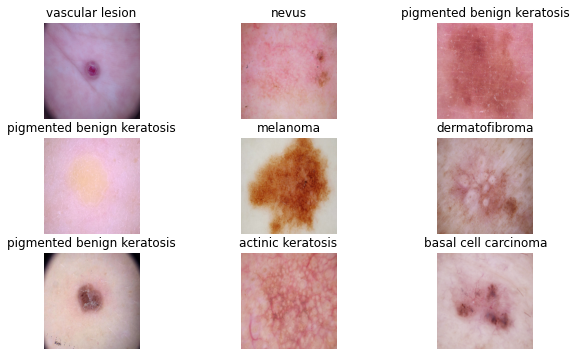

In [11]:
### your code goes here, you can use training or validation data to visualize
fig = plt.figure(figsize=(10,6))
for image,labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
    #print(image[i].shape)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:

### Your code goes here
num_classes = 9

# ### Standardize the image pixesl from [0,255] to [0, 1] using tf.keras.layers.Rescalling
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])

# #add layers
model.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

#model summmary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 44, 44, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 64)        1

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
## adam vs sgd... adam is faster... 
## If you have two or more classes and  the labels are integers, the SparseCategoricalCrossentropy should be used. 
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [15]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 167s 812ms/step - loss: 1.9215 - accuracy: 0.2801 - val_loss: 1.8436 - val_accuracy: 0.3691
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 1.5685 - accuracy: 0.4587 - val_loss: 1.5010 - val_accuracy: 0.4676
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4301 - accuracy: 0.4911 - val_loss: 1.4317 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3160 - accuracy: 0.5279 - val_loss: 1.3078 - val_accuracy: 0.5593
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.2360 - accuracy: 0.5569 - val_loss: 1.3254 - val_accuracy: 0.5727
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.2085 - accuracy: 0.5698 - val_loss: 1.3390 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.0986 - accuracy: 0.6055 - val_loss: 1.4394 - val_accuracy: 0.5213
Epoch 8/20

### Visualizing training results

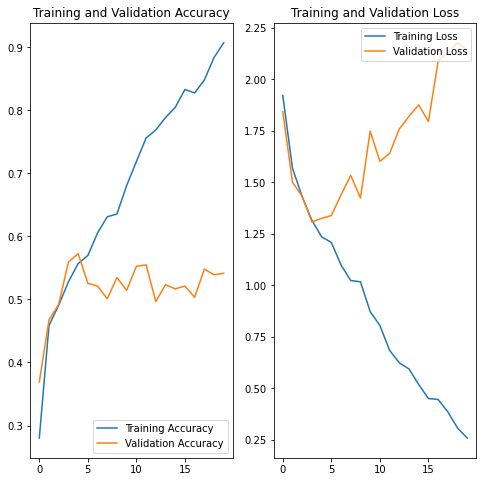

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
train_ds_gen = datagen.flow_from_directory(data_dir_train,target_size=(img_height,img_width),batch_size=batch_size,shuffle=True,classes=class_names,class_mode='sparse')


Found 2239 images belonging to 9 classes.


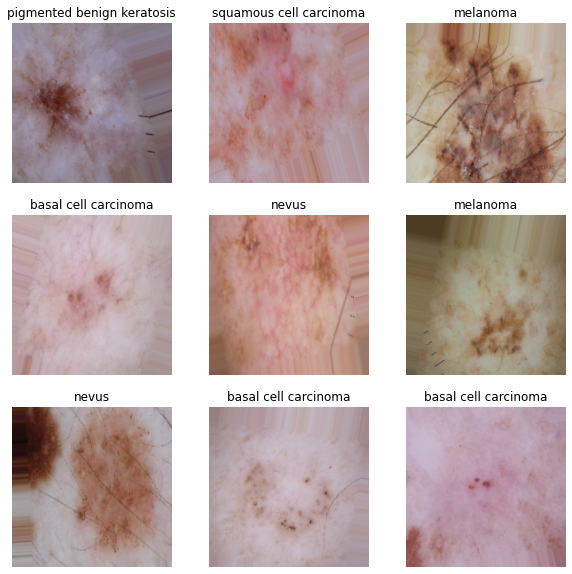

In [33]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for x,y in train_ds_gen:
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].astype("uint8"))
    plt.title(class_names[y[i].astype("uint8")])
    plt.axis('off')
  break

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# ### Standardize the image pixesl from [0,255] to [0, 1] using tf.keras.layers.Rescalling
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])

# #add layers
model.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

#model summmary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 88, 88, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 44, 44, 32)       0         
 2D)                                                  

### Compiling the model

In [34]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [35]:
type(train_ds_gen)

keras.preprocessing.image.DirectoryIterator

In [36]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds_gen,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 57s 813ms/step - loss: 2.4271 - accuracy: 0.1858 - val_loss: 2.0520 - val_accuracy: 0.2237
Epoch 2/20
70/70 [==============================] - 57s 817ms/step - loss: 1.9726 - accuracy: 0.2809 - val_loss: 1.9746 - val_accuracy: 0.2349
Epoch 3/20
70/70 [==============================] - 59s 838ms/step - loss: 1.8433 - accuracy: 0.3216 - val_loss: 1.7998 - val_accuracy: 0.3110
Epoch 4/20
70/70 [==============================] - 60s 862ms/step - loss: 1.6907 - accuracy: 0.3801 - val_loss: 1.8250 - val_accuracy: 0.2841
Epoch 5/20
70/70 [==============================] - 61s 871ms/step - loss: 1.6152 - accuracy: 0.4176 - val_loss: 1.5939 - val_accuracy: 0.4385
Epoch 6/20
70/70 [==============================] - 60s 860ms/step - loss: 1.6063 - accuracy: 0.4158 - val_loss: 1.5664 - val_accuracy: 0.4407
Epoch 7/20
70/70 [==============================] - 60s 858ms/step - loss: 1.5908 - accuracy: 0.4265 - val_loss: 1.5150 - val_accuracy: 0.4564

### Visualizing the results

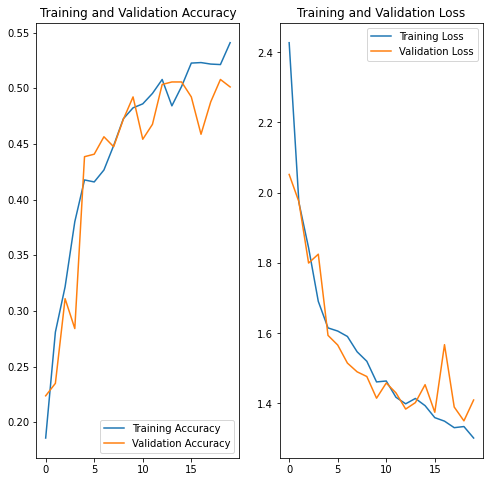

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Improvement is visible after doing augmentation

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [39]:
## Your code goes here.
from sklearn.datasets import load_files 
from keras.utils import np_utils


def load_data_raw (path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 9)
    
    return files, targets

train_filenames, train_targets = load_data_raw(data_dir_train)

<BarContainer object of 9 artists>

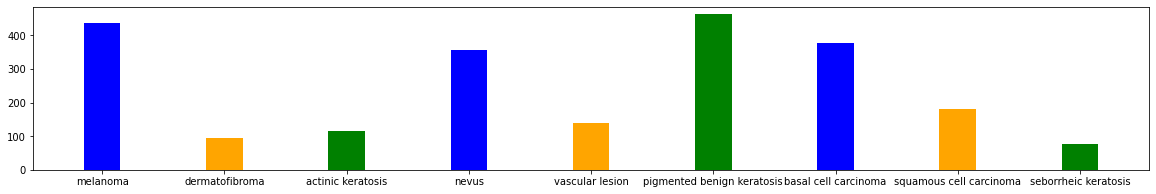

In [50]:
from collections import Counter
filenames_trimmed = [filename.split('/')[-2] for filename in train_filenames]
classes_count = Counter(filenames_trimmed)

# Plot the classes
plt.figure(figsize=(20, 3))
plt.bar(classes_count.keys(), classes_count.values(), color=['blue', 'orange', 'green'],width=0.3)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? --- seborrheic keratosis 
#### - Which classes dominate the data in terms proportionate number of samples? -pigmenred benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [51]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [52]:
path_to_training_dataset = "/content/gdrive/MyDrive/datasets/skin_db/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/skin_db/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F50C9FDB790>: 100%|██████████| 500/500 [00:21<00:00, 22.95 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/skin_db/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F50C378E090>: 100%|██████████| 500/500 [00:22<00:00, 22.26 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/skin_db/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F50C9FDB790>: 100%|██████████| 500/500 [00:22<00:00, 22.09 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/skin_db/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F5233776A90>: 100%|██████████| 500/500 [01:42<00:00,  4.86 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/skin_db/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F50C600F450>: 100%|██████████| 500/500 [01:30<00:00,  5.51 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/skin_db/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F513EBEC110>: 100%|██████████| 500/500 [00:23<00:00, 21.73 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/skin_db/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5232F31FD0>: 100%|██████████| 500/500 [00:52<00:00,  9.44 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/skin_db/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F51B99BB750>: 100%|██████████| 500/500 [00:23<00:00, 21.66 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/skin_db/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F50CA01C090>: 100%|██████████| 500/500 [00:23<00:00, 21.34 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [53]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [54]:
import glob
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list_new)

4500

In [55]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(set(lesion_list_new))

{'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'seborrheic keratosis', 'pigmented benign keratosis', 'vascular lesion', 'actinic keratosis', 'squamous cell carcinoma'}


In [56]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict_new

{'/content/gdrive/MyDrive/datasets/skin_db/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027678.jpg_d58ff88c-b13b-481a-8279-34781cf7bc5c.jpg': 'squamous cell carcinoma',
 '/content/gdrive/MyDrive/datasets/skin_db/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029860.jpg_df9363be-5e49-408b-b7eb-5e1ce990b08e.jpg': 'squamous cell carcinoma',
 '/content/gdrive/MyDrive/datasets/skin_db/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030591.jpg_00b7c1c8-8183-4f43-92fd-e3cebade7b28.jpg': 'squamous cell carcinoma',
 '/content/gdrive/MyDrive/datasets/skin_db/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028872.jpg_62394ecc-f7d4-45ec-ae65-22b9ef0d0219.jpg': 'squamous cell carcinoma',
 '/content/gdrive/MyDrive/datasets/skin_db/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026100.jpg_23bd9fe2-d72f-4c30-9e9d-3397207e22e6.jpg': 'squamous cell carcinoma',


In [57]:
path_list=[x for x in glob.glob(os.path.join(data_dir_train,'*','*.jpg'))]
len(path_list)

2239

In [58]:
lesion_list= [i.split('/')[-2] for i in path_list]
len(lesion_list)

2239

In [59]:
dataframe_dict = dict(zip(path_list, lesion_list))

In [60]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [61]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [62]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [63]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [64]:
data_dir_train="/content/gdrive/MyDrive/datasets/skin_db/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [65]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [66]:
## your code goes here

# ### Standardize the image pixesl from [0,255] to [0, 1] using tf.keras.layers.Rescalling
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])

# #add layers
model.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

#model summmary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 88, 88, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 44, 44, 32)       0         
 2D)                                                  

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [67]:
## your code goes here
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [68]:
epochs = 30
## Your code goes here, use 50 epochs.
history =  model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 41s 229ms/step - loss: 2.2932 - accuracy: 0.1471 - val_loss: 2.1276 - val_accuracy: 0.1997
Epoch 2/30
169/169 [==============================] - 39s 223ms/step - loss: 1.8375 - accuracy: 0.3040 - val_loss: 1.6749 - val_accuracy: 0.4068
Epoch 3/30
169/169 [==============================] - 40s 227ms/step - loss: 1.4772 - accuracy: 0.4436 - val_loss: 1.4470 - val_accuracy: 0.4633
Epoch 4/30
169/169 [==============================] - 39s 225ms/step - loss: 1.3446 - accuracy: 0.5011 - val_loss: 1.3983 - val_accuracy: 0.5011
Epoch 5/30
169/169 [==============================] - 40s 227ms/step - loss: 1.2061 - accuracy: 0.5458 - val_loss: 1.2781 - val_accuracy: 0.5316
Epoch 6/30
169/169 [==============================] - 40s 226ms/step - loss: 1.1127 - accuracy: 0.5875 - val_loss: 1.2042 - val_accuracy: 0.5471
Epoch 7/30
169/169 [==============================] - 40s 226ms/step - loss: 1.0340 - accuracy: 0.6222 - val_loss: 1.1918 - val_accuracy: 0.5

#### **Todo:**  Visualize the model results

In [1]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Yes. 